In [190]:
using Gen
using Flux
using JLD
using Random
using StatsBase
using LinearAlgebra
using PyPlot
using Distributions

include("LoadData.jl")
include("NUTS.jl")
include("utils.jl");

In [191]:
#Load Boston Housing Data

dx, dy, x_train, x_test, y_train, y_test = load_data(10);

In [192]:
#Network Hyperparameters

#Network hyperparameters
k_real = 4 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 8 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1;

In [193]:
#Bayesian Neural Network 

function G(x, trace)
    d = 13
    activation = relu
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:l]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

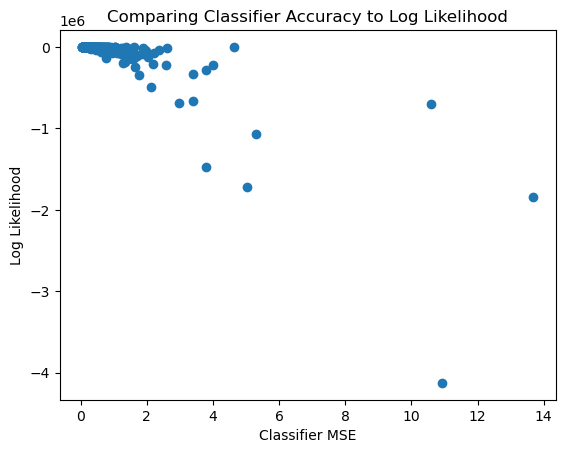

Best noise variance: 0.4432502171013551
Best MSE: 0.48673204704746686
Best Score: -423.0333303610554
Best layer count: 1


In [197]:
#Probabilistic Model

@gen function interpolator(x)
    
    d = length(x[:,1])
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #####################################
    #New hyperparameter schedule - Mar 8#
    #####################################
    
    #Standard Deviations
    τ₁ ~ gamma(100,0.01) #(100,0.01) Hidden weights and biases
    τ₂ ~ gamma(100*4,0.01) #(100*k,0.01) Output weights and biases
    #τᵧ ~ gamma(100,0.2) #(100,0.5)
    τᵧ ~ gamma(1,1)
    
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σᵧ = 1/τᵧ
    
    #Sample weight and bias vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]

    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            u = zeros(h)
            S = Diagonal([σ₁ for i=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            ub = zeros(k[i])
            Sb = Diagonal([σ₁ for i=1:length(ub)])    
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            u = zeros(k[l])
            S = Diagonal([σ₂ for i=1:length(u)])
            W[i] = @trace(mvnormal(u,S), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            ub = zeros(1)
            Sb = Diagonal([σ₂ for i=1:length(ub)])  
            b[i] = @trace(mvnormal(ub,Sb), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = transpose(G(x,obs))[:,1]
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))

    return scores
    
end

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_train
obs = obs_master;
(trace,) = generate(interpolator, (x_train,), obs);

#----------------
#Test Likelihood
#----------------
best_trace, scores, mses = likelihood_regression(x_train, y_train, 1000)
PyPlot.scatter(mses, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier MSE")
plt.ylabel("Log Likelihood")

pred_y = transpose(G(x_train,best_trace))[:,1]
best_mse = mse_scaled(pred_y, y_train)
variance = 1/(best_trace[:τᵧ])
println("Best noise variance: $variance")
println("Best MSE: $best_mse")
println("Best Score: $(get_score(best_trace))")
println("Best layer count: $(best_trace[:l])")

1
1.0040904003911313
[NUTS] start sampling for 201 samples with inital ϵ=1
.........................................................................................................................................................................................................


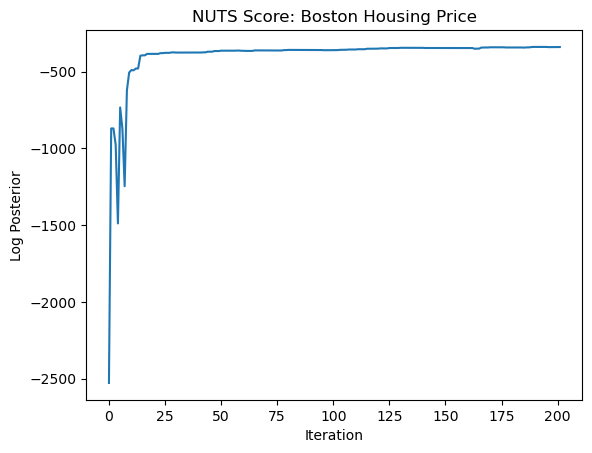

[NUTS] sampling complete with final apated ϵ = 0.054110781138541134


In [204]:
#Straight NUTS
Δ_max = 1000
#obs[:l] = 8
(trace,) = generate(interpolator, (x_train,), obs)
println(trace[:l])
#trace = best_trace
sigma = 1/(trace[:τᵧ]) #Best so far: 3.0483
println("$sigma")

#Trace 1
param_selection = select()

for i=1:trace[:l]+1 #Number of Layers
    push!(param_selection, (:W,i))
    push!(param_selection, (:b,i))
end

m=200

traces = NUTS(trace, param_selection, 0.95, m+1, 3, true); #m+1, m=100, 0.65
#accs = []

#-----------------------------------
#Plot Log Posterior Scores by Trace
#-----------------------------------

plot([get_score(trace) for trace in traces])
plt.title("NUTS Score: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("Log Posterior");

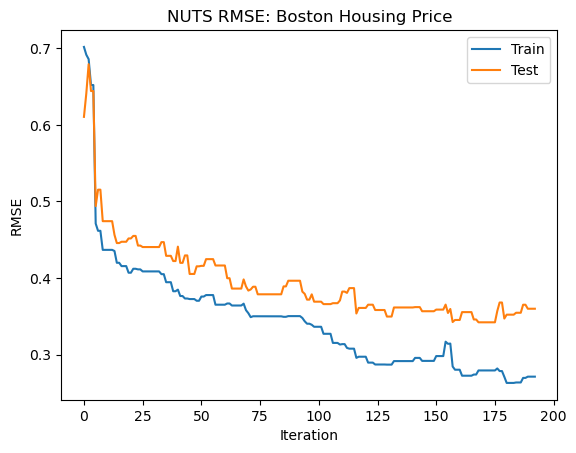

In [205]:
#-------------------------------
#Plot RMSE Train Scores by Trace
#-------------------------------

mses_train = []
for i=10:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    mse = mse_scaled(pred_y,y_train)

    push!(mses_train,mse)
end

mses_test = []
for i=10:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    mse = mse_scaled(pred_y,y_test)

    push!(mses_test,mse)
end

plot(mses_train,label="Train")
plot(mses_test, label="Test")
plt.title("NUTS RMSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("RMSE");
plt.legend()

best_trace = traces[1]
for i=1:length(traces)
    if get_score(traces[i]) > get_score(best_trace)
        best_trace = traces[i]
    end
end

In [206]:
#----------------
#Marginalize RMSE
#----------------
j = 1
y_marginal = zeros(length(y_train))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_train,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_train)
println("Training Set Marginal RMSE: $mse")

j = 20
y_marginal = zeros(length(y_test))

for i=j:length(traces)
    trace = traces[i]
    pred_y = transpose(G(x_test,trace))[:,1]
    y_marginal += (pred_y/(length(traces)-j))
end

#display(y_marginal[1:5])
#display(y[1:5])

mse = mse_scaled(y_marginal, y_test)
println("Test Set Marginal RMSE: $mse")

Training Set Marginal RMSE: 0.29434089910891603
Test Set Marginal RMSE: 0.3519912911511289


In [ ]:
#NUTS with Hyperparam Sampling

traces = []
for i=1:100
    prev_trace = trace
    trace = NUTS(trace, param_selection, 0.25, m+1, m, false)[m+1];
       
    hyper_selection = select()
    push!(hyper_selection, :τᵧ)
    (trace, _, _) = regenerate(trace, hyper_selection)
    
    u = rand(Uniform(0,1))
    score = get_score(trace) - get_score(prev_trace)
    if log(u) < score
        trace = trace
        if score == 0
            push!(accs,0)
        else
            push!(accs,1)
        end
    else
        trace = prev_trace
        push!(accs,0)
    end
    push!(traces,trace)
    
    if i%10 == 0
        println("Epoch $i Acceptance: $(sum(accs)/length(accs))")
    end
end

In [ ]:
#Bayesian Neural Net (Function)
function G(x, 
        trace, 
        activation=sigmoid
    )
    
    d = length(x[:,1]) #Dimension

    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    
    for i=1:l
        in_dim, out_dim = layer_unpacker(i, l, ks, d)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,l+1)], 1, ks[l])
    bₒ = reshape(trace[(:b,l+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

In [ ]:
#Run Inference